In [1]:
from astropy.io import fits
from astropy.utils.data import get_pkg_data_filename

import os
import glob

import numpy as np

In [2]:
pathToPos = 'top1500processed/top1500processed_pos/'
pathToNeg = 'top1500processed/top1500processed_neg/'

In [3]:
#pathToPos = 'PositiveWithDESSky/'
#pathToNeg = 'DES/DES_Processed'

In [4]:
folders = {}
for root, dirs, files in os.walk(pathToPos):
    for folder in dirs:
        key = folder
        value = os.path.join(root, folder)
        folders[key] = value
        
# subf = []
# for folder in folders:
#     subf.append(folder[len(pathToPos)])

In [5]:
#number of Positive DataPoints
nDT = len(folders)

DataPos = np.zeros([nDT, 3, 100, 100])

# key is name of folder number
# value is the number of the folder to be added to the file name

counter = 0
for key, value in folders.items():
    g_name = get_pkg_data_filename(value + '/' + str(key) + '_posSky_g_norm.fits')
    r_name = get_pkg_data_filename(value + '/' + str(key) + '_posSky_r_norm.fits')
    i_name = get_pkg_data_filename(value + '/' + str(key) + '_posSky_i_norm.fits')
    
#    g_name = get_pkg_data_filename(folders[var]+'/'+subf[var]+'g_WCSClipped.fits')
#    r_name = get_pkg_data_filename(folders[var]+'/'+subf[var]+'r_WCSClipped.fits')
#    i_name = get_pkg_data_filename(folders[var]+'/'+subf[var]+'i_WCSClipped.fits')
    
    
    g = fits.open(g_name)[0].data[0:100,0:100]
    r = fits.open(r_name)[0].data[0:100,0:100]
    i = fits.open(i_name)[0].data[0:100,0:100]
    
    DataPos[counter] = [g, r, i] 
    counter += 1
#    if counter > 1500:
#        break

In [6]:
#Loading negative examples

# r=root, d=directories, f = files

foldersNeg = []
for root, dirs, files in os.walk(pathToNeg):
    for folder in dirs:
        foldersNeg.append(os.path.join(root, folder))

In [7]:
nDT = len(foldersNeg)
DataNeg = np.zeros([nDT,3,100,100])

for var in range(len(folders)):
#    g_name = get_pkg_data_filename(foldersNeg[var]+'/g_WCSClipped.fits')
#    r_name = get_pkg_data_filename(foldersNeg[var]+'/r_WCSClipped.fits')
#    i_name = get_pkg_data_filename(foldersNeg[var]+'/i_WCSClipped.fits')    

    g_name = get_pkg_data_filename(foldersNeg[var]+'/g_norm.fits')
    r_name = get_pkg_data_filename(foldersNeg[var]+'/r_norm.fits')
    i_name = get_pkg_data_filename(foldersNeg[var]+'/i_norm.fits')    

    g = fits.open(g_name)[0].data[0:100,0:100]
    r = fits.open(r_name)[0].data[0:100,0:100]
    i = fits.open(i_name)[0].data[0:100,0:100]    
    
    DataNeg[var] = [g, r, i]
#    if var > 1500:
#        break

In [8]:
def norm(x):
    m = x.mean()
    v = x.std()
    return (x-m)/v

In [9]:
from matplotlib import pyplot
im2disp = DataNeg[20].transpose((1,2,0))
pyplot.imshow(im2disp)
pyplot.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 640x480 with 1 Axes>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


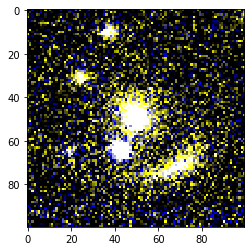

In [10]:
im2disp = DataPos[20].transpose((1,2,0))
pyplot.imshow(im2disp)
pyplot.show()

In [11]:
DataPos.std()

0.9999999999999988

I have found an issue here:
   DEF: The std is the quantity expressing by how much the members of a group differ from the mean value for the group.
   
   DataPos has a very low std, and this means that all the images are very similar. This is not exactly what we want as this doesnt have a huge difference when training, testing or validating. 
   
   Since DataNeg std is so much bigger, there is quite a large variety

In [12]:
DataNeg.std()

1.000638688308503

In [ ]:
# Gaussian normalization of the data
for i in range(DataPos.shape[0]):
    for j in range(DataPos.shape[1]):
        DataPos[i,j] = norm(DataPos[i,j])
        #print(DataPos.std())

for i in range(DataNeg.shape[0]):
    for j in range(DataNeg.shape[1]):
        DataNeg[i,j] = norm(DataNeg[i,j])
        #print(DataNeg.std())
        

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


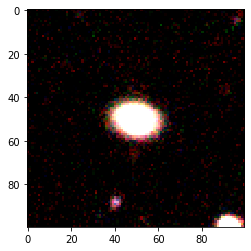

In [13]:
from matplotlib import pyplot
im2disp = DataNeg[20].transpose((1,2,0))
pyplot.imshow(im2disp)
pyplot.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


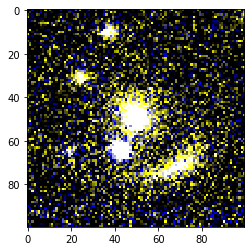

In [14]:
im2disp = DataPos[20].transpose((1,2,0))
pyplot.imshow(im2disp)
pyplot.show()

In [15]:
# We need to create train and test "datasets",
# let's say 80% images for training and 20% for test from every group

In [16]:
DataPos.shape[0]
DataNeg.shape[0]

1500

In [17]:
import numpy.random as rnd
rnd.seed(2019) #fix seed for reproducibility of results 

listPos = list(np.arange(DataPos.shape[0]))
listPosTest = list(rnd.choice(listPos,int(DataPos.shape[0]*0.2), replace=False))
listPosRem = list(set(listPos)-set(listPosTest))
listPosVal = list(rnd.choice(listPosRem,int(DataPos.shape[0]*0.2), replace=False))
listPosTrain = list(set(listPosRem)-set(listPosVal))


listNeg = list(np.arange(DataPos.shape[0],DataPos.shape[0]+DataNeg.shape[0]))
listNegTest  = list(rnd.choice(listNeg,int(DataNeg.shape[0]*0.2), replace=False))
listNegRem = list(set(listNeg)-set(listNegTest))
listNegVal  = list(rnd.choice(listNegRem,int(DataNeg.shape[0]*0.2), replace=False))
listNegTrain = list(set(listNegRem)-set(listNegVal))

listTest  = listPosTest  + listNegTest
rnd.shuffle(listTest)
listVal  = listPosVal  + listNegVal
rnd.shuffle(listVal)
listTrain = listPosTrain + listNegTrain
rnd.shuffle(listTrain)

In [18]:
#Now we are ready to create X_train, Y_train and X_test and Y_test

Ntest  = len(listTest)
Nval   = len(listVal)
Ntrain = len(listTrain)

X_train = np.zeros([Ntrain,3,100,100])
Y_train = np.zeros(Ntrain, dtype=int)

X_test = np.zeros([Ntest,3,100,100])
Y_test = np.zeros(Ntest, dtype=int)

X_val = np.zeros([Nval,3,100,100])
Y_val = np.zeros(Nval, dtype=int)


for i in range(Ntest):
    if listTest[i]<DataPos.shape[0]:
        X_test[i] = DataPos[listTest[i]]
        Y_test[i] = 1
    else:
        X_test[i] = DataNeg[listTest[i]-DataPos.shape[0]]
        Y_test[i] = 0

for i in range(Nval):
    if listVal[i]<DataPos.shape[0]:
        X_val[i] = DataPos[listVal[i]]
        Y_val[i] = 1
    else:
        X_val[i] = DataNeg[listVal[i]-DataPos.shape[0]]
        Y_val[i] = 0        
        
for i in range(Ntrain):
    if listTrain[i]<DataPos.shape[0]:
        X_train[i] = DataPos[listTrain[i]]
        Y_train[i] = 1
    else:
        X_train[i] = DataNeg[listTrain[i]-DataPos.shape[0]]
        Y_train[i] = 0

In [19]:
X_test  = X_test.transpose(0,2,3,1)
X_val   = X_val.transpose(0,2,3,1)
X_train = X_train.transpose(0,2,3,1)

In [20]:
#Now we are almost ready to create CNN :)

In [21]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Flatten, Dense, Dropout

Using TensorFlow backend.


In [22]:
model = Sequential()
model.add(Conv2D(8, kernel_size = (3, 3), activation='relu', input_shape=(100, 100, 3)))
model.add(MaxPooling2D(pool_size=(4,4)))
model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dense(1))
model.add(Activation('sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [23]:
model.fit(X_train, Y_train, epochs=30, batch_size=200, validation_data=(X_val, Y_val))

Train on 1800 samples, validate on 600 samples
Epoch 1/30
1800/1800 [==============================] - 5s 3ms/step - loss: 2.3628 - accuracy: 0.6933 - val_loss: 0.1990 - val_accuracy: 0.9483
Epoch 2/30
1800/1800 [==============================] - 4s 2ms/step - loss: 0.5909 - accuracy: 0.8167 - val_loss: 0.1742 - val_accuracy: 0.9533
Epoch 3/30
1800/1800 [==============================] - 4s 2ms/step - loss: 0.0777 - accuracy: 0.9833 - val_loss: 0.1522 - val_accuracy: 0.9650
Epoch 4/30
1800/1800 [==============================] - 4s 2ms/step - loss: 0.0517 - accuracy: 0.9872 - val_loss: 0.1446 - val_accuracy: 0.9683
Epoch 5/30
1800/1800 [==============================] - 4s 2ms/step - loss: 0.5339 - accuracy: 0.8778 - val_loss: 0.1667 - val_accuracy: 0.9617
Epoch 6/30
1800/1800 [==============================] - 4s 2ms/step - loss: 0.0372 - accuracy: 0.9906 - val_loss: 0.1554 - val_accuracy: 0.9617
Epoch 7/30
1800/1800 [==============================] - 4s 2ms/step - loss: 0.0242 - accu

In [24]:
# You can add more layers, DropOut and others

In [25]:
model.save_weights('model_baseline.h5')

In [26]:
_, acc = model.evaluate(X_test, Y_test, verbose=0)
print("accuracy on the test set ->", acc * 100.0)

accuracy on the test set -> 96.33333086967468


In [27]:
np.round(model.predict(X_test))

array([[1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],

In [28]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 98, 98, 8)         224       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 8)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               589952    
_________________________________________________________________
activation_1 (Activation)    (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
_________________________________________________________________
activation_2 (Activation)    (None, 1)                

In [29]:
DataPos.dump('DataPos.pkl')
DataNeg.dump('DataNeg.pkl')

# Test 84 good and 84 bad images.

In [58]:
# get path names for good and bad sources, where good sources are the 
# known sources and the bad sources are the unknown sources

pathToKnown = 'KnownLenses/Known_Processed'
pathToUnknown = 'DES/Unknown'

In [59]:
# Loading known examples from Jacobs paper

# r=root, d=directories, f = files

foldersKnown = []
for root, dirs, files in os.walk(pathToKnown):
    for folder in dirs:
        foldersKnown.append(os.path.join(root, folder))

In [60]:
nDT = len(foldersKnown)
DataKnown = np.zeros([nDT,3,100,100])

for var in range(len(foldersKnown)):
#    g_name = get_pkg_data_filename(foldersKnown[var]+'/g_WCSClipped.fits')
#    r_name = get_pkg_data_filename(foldersKnown[var]+'/r_WCSClipped.fits')
#    i_name = get_pkg_data_filename(foldersKnown[var]+'/i_WCSClipped.fits')    

    g_name = get_pkg_data_filename(foldersKnown[var]+'/g_norm.fits')
    r_name = get_pkg_data_filename(foldersKnown[var]+'/r_norm.fits')
    i_name = get_pkg_data_filename(foldersKnown[var]+'/i_norm.fits')    

    g = fits.open(g_name)[0].data[0:100,0:100]
    r = fits.open(r_name)[0].data[0:100,0:100]
    i = fits.open(i_name)[0].data[0:100,0:100]    
    
    DataKnown[var] = [g, r, i]

In [61]:
# Loading unknown examples from DES

foldersUnknown = []
for root, dirs, files in os.walk(pathToUnknown):
    for folder in dirs:
        foldersUnknown.append(os.path.join(root, folder))

In [62]:
nDT = len(foldersUnknown)
DataUnknown = np.zeros([nDT,3,100,100])

for var in range(len(foldersUnknown)):
#    g_name = get_pkg_data_filename(foldersUnknown[var]+'/g_WCSClipped.fits')
#    r_name = get_pkg_data_filename(foldersUnknown[var]+'/r_WCSClipped.fits')
#    i_name = get_pkg_data_filename(foldersUnknown[var]+'/i_WCSClipped.fits')    

    g_name = get_pkg_data_filename(foldersUnknown[var]+'/g_norm.fits')
    r_name = get_pkg_data_filename(foldersUnknown[var]+'/r_norm.fits')
    i_name = get_pkg_data_filename(foldersUnknown[var]+'/i_norm.fits')    

    g = fits.open(g_name)[0].data[0:100,0:100]
    r = fits.open(r_name)[0].data[0:100,0:100]
    i = fits.open(i_name)[0].data[0:100,0:100]    
    
    DataUnknown[var] = [g, r, i]

In [63]:
DataKnown = DataKnown.transpose(0, 3, 2, 1)
np.round(model.predict(DataKnown))
print ("Non zeros: " +str(np.count_nonzero(model.predict(DataKnown))))
print ("length: "+ str(len(DataKnown)))

Non zeros: 79
length: 84


In [66]:
DataUnknown = DataUnknown.transpose(0, 3, 2, 1 )
np.round(model.predict(DataUnknown))
print ("Non zeros: " +str(np.count_nonzero(model.predict(DataUnknown))))
print ("length: "+ str(len(DataUnknown)))

Non zeros: 23
length: 84
